In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import shutil

import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.5.1+cu121
device: cuda


In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files

# Prompt to upload the kaggle.json file
files.upload()

# Move the kaggle.json file to the appropriate location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the downloaded dataset
!unzip chest-xray-pneumonia.zip -d chest_xray_data


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NO

In [ ]:
!pwd

/content/DCGAN-and-cGAN-implementations-for-chest-xray


In [ ]:
os.listdir('./chest_xray_data')
# Function to create a csv containing image path and labels from folders of images
def create_csv(data_dir, csv_name):
    data = []
    for folder in os.listdir(data_dir):
        if folder in ['NORMAL', 'PNEUMONIA']:
            for file in os.listdir(data_dir + folder):
                data.append([data_dir + folder + '/' + file, folder])
    df = pd.DataFrame(data, columns=['image', 'label'])
    df.to_csv(csv_name, index=False)
    print('CSV created')
    # Print and format number of instances in each class and total instances
    print(df['label'].value_counts())
    # Draw plot for percentage of instances in each class and add labels
    plt.figure(figsize=(5, 5))
    df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%').set_title(csv_name)
    # Save csv to suitable location
    df.to_csv(csv_name, index=False)
    return df

CSV created
label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64
CSV created
label
PNEUMONIA    8
NORMAL       8
Name: count, dtype: int64
CSV created
label
PNEUMONIA    390
NORMAL       234
Name: count, dtype: int64


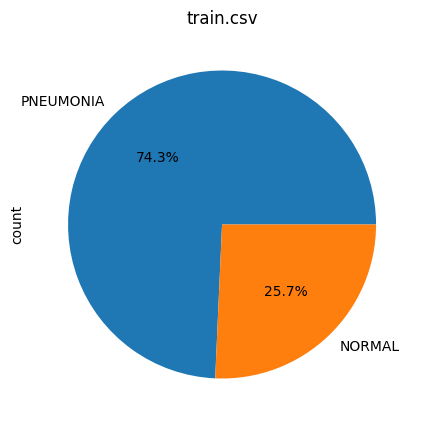

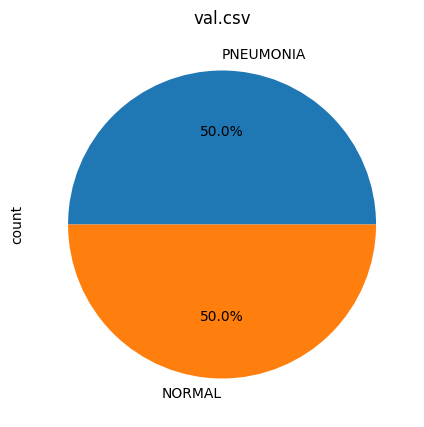

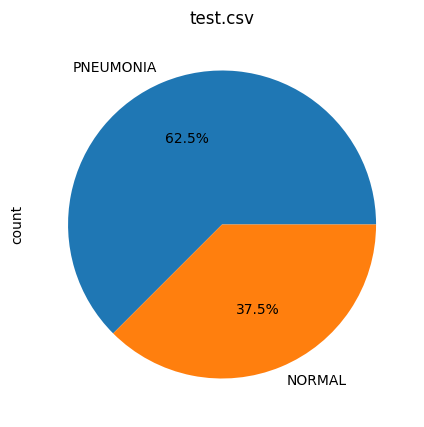

In [ ]:
train_csv = create_csv('/content/DCGAN-and-cGAN-implementations-for-chest-xray/chest_xray_data/chest_xray/train/', 'train.csv')
val_csv = create_csv('/content/DCGAN-and-cGAN-implementations-for-chest-xray/chest_xray_data/chest_xray/val/', 'val.csv')
test_csv = create_csv('/content/DCGAN-and-cGAN-implementations-for-chest-xray/chest_xray_data/chest_xray/test/', 'test.csv')

In [ ]:
# Data
train_data_path = './train.csv' # Path of data
valid_data_path = './test.csv' # Path of data
print('Train data path:', train_data_path)
print('Valid data path:', valid_data_path)

img_size = 64 # Image size
batch_size = 64  # Batch size

# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# Training
epochs = 100  # Train epochs
learning_rate = 1e-4

Train data path: ./train.csv
Valid data path: ./test.csv


In [ ]:
class_list = ['NORMAL', 'PNEUMONIA']
class_num = len(class_list)

In [ ]:
# Function to find normalizing parameters for data
def find_mean_std(data_path):
    df = pd.read_csv(data_path)
    mean = 0.
    std = 0.
    nb_samples = 0.
    for i in range(len(df)):
        img = Image.open(df['image'][i])
        img = np.array(img)/255
        mean += np.mean(img)
        std += np.std(img)
        nb_samples += 1.
    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [ ]:
# Pytorch dataset that loads images and labels from csv
class ChestXrayDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name).convert('RGB')
        label = 1 if self.data.iloc[idx, 1] == 'PNEUMONIA' else 0
        if self.transform:
            image = self.transform(image)
        return image, label

# Pytorch dataloader that loads data from dataset and resizes image to 256x256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.354,), std=(0.4435,))
])
train_data = ChestXrayDataset(train_data_path, transform)
valid_data = ChestXrayDataset(valid_data_path, transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,drop_last=True)

In [ ]:
# Check if dataloader is working
for i, (images, labels) in enumerate(train_loader):
    print(images.shape, labels)
    # Show images
    plt.figure(figsize=(16, 24))
    plt.axis("off")
    plt.title("Training Images")
    # Make grid from images and plot labels
    plt.imshow(np.transpose(make_grid(images, nrow=8).cpu(), (1, 2, 0)))
    break


In [ ]:

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")


# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):


        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/100][0/81]	Loss_D: 1.9954	Loss_G: 4.3607	D(x): 0.5023	D(G(z)): 0.6283 / 0.0213
[0/100][50/81]	Loss_D: 0.0211	Loss_G: 9.8849	D(x): 0.9971	D(G(z)): 0.0178 / 0.0001
[1/100][0/81]	Loss_D: 1.1043	Loss_G: 18.6014	D(x): 0.9501	D(G(z)): 0.5372 / 0.0000
[1/100][50/81]	Loss_D: 1.4431	Loss_G: 7.4724	D(x): 0.4115	D(G(z)): 0.0006 / 0.0010
[2/100][0/81]	Loss_D: 0.4560	Loss_G: 6.7025	D(x): 0.8935	D(G(z)): 0.2256 / 0.0021
[2/100][50/81]	Loss_D: 1.1013	Loss_G: 8.7972	D(x): 0.8998	D(G(z)): 0.5258 / 0.0004
[3/100][0/81]	Loss_D: 0.5012	Loss_G: 3.5676	D(x): 0.7170	D(G(z)): 0.0484 / 0.0446
[3/100][50/81]	Loss_D: 0.3184	Loss_G: 2.9908	D(x): 0.8996	D(G(z)): 0.1448 / 0.0796
[4/100][0/81]	Loss_D: 0.5876	Loss_G: 7.2144	D(x): 0.9667	D(G(z)): 0.3884 / 0.0019
[4/100][50/81]	Loss_D: 0.5026	Loss_G: 5.6201	D(x): 0.9083	D(G(z)): 0.2855 / 0.0110
[5/100][0/81]	Loss_D: 0.3133	Loss_G: 3.1019	D(x): 0.8423	D(G(z)): 0.0915 / 0.0965
[5/100][50/81]	Loss_D: 0.3712	Loss_G: 3.9223	D(x): 0.8646	D(G(z)):

In [ ]:
# Save model weights
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')


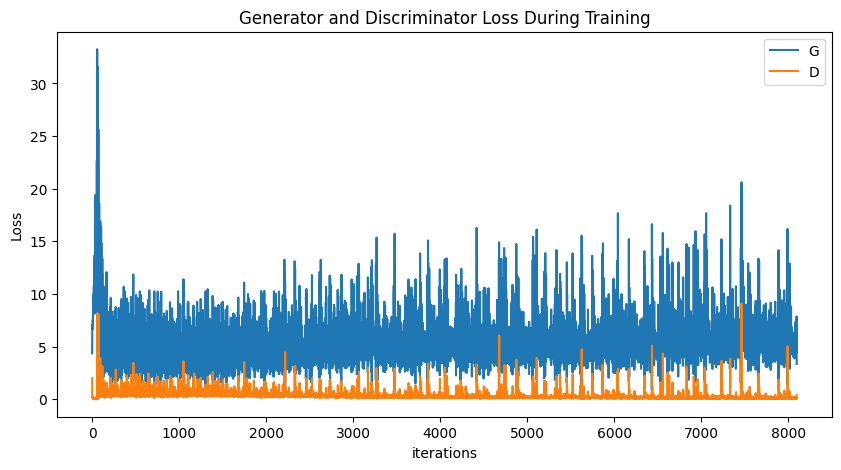

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(14,14))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

cGAN

In [ ]:


# Arguments
BATCH_SIZE = 64
Z_DIM = 10
LABEL_EMBED_SIZE = 5
NUM_CLASSES = 2
IMGS_TO_DISPLAY_PER_CLASS = 8
LOAD_MODEL = False

DB = 'CHEST_XRAY'
CHANNELS = 3
EPOCHS = 100


# Directories for storing data, model and output samples
db_path = os.path.join('./data', DB)
os.makedirs(db_path, exist_ok=True)
model_path = os.path.join('./model', DB)
os.makedirs(model_path, exist_ok=True)
samples_path = os.path.join('./samples', DB)
os.makedirs(samples_path, exist_ok=True)



In [ ]:


def generate_imgs(gen, z, fixed_label, img_list, epoch=0):
    gen.eval()
    fake_imgs = gen(z, fixed_label)
    fake_imgs = (fake_imgs + 1) / 2
    fake_imgs_ = vutils.make_grid(fake_imgs, normalize=False, nrow=IMGS_TO_DISPLAY_PER_CLASS)
    img_list.append(fake_imgs_)
    vutils.save_image(fake_imgs_, os.path.join(samples_path, 'sample_' + str(epoch) + '.png'))


# Networks
def conv_block(c_in, c_out, k_size=4, stride=2, pad=1, use_bn=True, transpose=False):
    module = []
    if transpose:
        module.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    else:
        module.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    if use_bn:
        module.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*module)


In [ ]:


class Generator(nn.Module):
    def __init__(self, z_dim=10, num_classes=2, label_embed_size=5, channels=3, conv_dim=64):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, label_embed_size)
        self.tconv1 = conv_block(z_dim + label_embed_size, conv_dim * 4, pad=0, transpose=True)
        self.tconv2 = conv_block(conv_dim * 4, conv_dim * 2, transpose=True)
        self.tconv3 = conv_block(conv_dim * 2, conv_dim * 2, transpose=True)
        self.tconv4 = conv_block(conv_dim * 2, conv_dim, transpose=True)
        self.tconv5 = conv_block(conv_dim, channels, transpose=True, use_bn=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, label):
        x = x.reshape([x.shape[0], -1, 1, 1])
        label_embed = self.label_embedding(label)
        label_embed = label_embed.reshape([label_embed.shape[0], -1, 1, 1])
        x = torch.cat((x, label_embed), dim=1)
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = F.relu(self.tconv3(x))
        x = F.relu(self.tconv4(x))
        x = torch.tanh(self.tconv5(x))
        return x


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_classes=2, channels=3, conv_dim=64):
        super(Discriminator, self).__init__()
        self.image_size = img_size
        self.label_embedding = nn.Embedding(num_classes, self.image_size*self.image_size)
        self.conv1 = conv_block(channels + 1, conv_dim, use_bn=False)
        self.conv2 = conv_block(conv_dim, conv_dim * 2)
        self.conv3 = conv_block(conv_dim * 2, conv_dim * 4)
        self.conv4 = conv_block(conv_dim * 4, conv_dim * 6)
        self.conv5 = conv_block(conv_dim * 6, 1, k_size=4, stride=1, pad=0, use_bn=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, label):
        alpha = 0.2
        label_embed = self.label_embedding(label)
        label_embed = label_embed.reshape([label_embed.shape[0], 1, self.image_size, self.image_size])
        x = torch.cat((x, label_embed), dim=1)
        x = F.leaky_relu(self.conv1(x), alpha)
        x = F.leaky_relu(self.conv2(x), alpha)
        x = F.leaky_relu(self.conv3(x), alpha)
        x = F.leaky_relu(self.conv4(x), alpha)
        x = torch.sigmoid(self.conv5(x))
        return x.squeeze()



In [ ]:

gen = Generator(z_dim=Z_DIM, num_classes=NUM_CLASSES, label_embed_size=LABEL_EMBED_SIZE, channels=CHANNELS)
dis = Discriminator(num_classes=NUM_CLASSES, channels=CHANNELS)

# Load previous model
if LOAD_MODEL:
    gen.load_state_dict(torch.load(os.path.join(model_path, 'gen.pkl')))
    dis.load_state_dict(torch.load(os.path.join(model_path, 'dis.pkl')))

# Model Summary
print("------------------Generator------------------")
print(gen)
print("------------------Discriminator------------------")
print(dis)


------------------Generator------------------
Generator(
  (label_embedding): Embedding(2, 5)
  (tconv1): Sequential(
    (0): ConvTranspose2d(15, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv3): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv5): Sequential(
    (0): ConvTranspose2d(64, 3, kerne

In [ ]:

# Define Optimizers
g_opt = torch.optim.Adam(gen.parameters(), lr=0.00005, betas=(0.5, 0.999), weight_decay=2e-5)
d_opt = torch.optim.Adam(dis.parameters(), lr=0.00005, betas=(0.5, 0.999), weight_decay=2e-5)

# Loss functions
loss_fn = nn.BCELoss()

# Fix images for viz
fixed_z = torch.randn(IMGS_TO_DISPLAY_PER_CLASS*NUM_CLASSES, Z_DIM)
fixed_label = torch.arange(0, NUM_CLASSES)
fixed_label = torch.repeat_interleave(fixed_label, IMGS_TO_DISPLAY_PER_CLASS)



In [ ]:
len(train_loader)

81

In [ ]:
# Labels
real_label = torch.ones(BATCH_SIZE)
fake_label = torch.zeros(BATCH_SIZE)
img_list = []
G_losses = []
D_losses = []

# GPU Compatibility
is_cuda = torch.cuda.is_available()
if is_cuda:
    gen, dis = gen.cuda(), dis.cuda()
    real_label, fake_label = real_label.cuda(), fake_label.cuda()
    fixed_z, fixed_label = fixed_z.cuda(), fixed_label.cuda()

total_iters = 0
max_iter = len(train_loader)

# Training
for epoch in range(EPOCHS):
    gen.train()
    dis.train()

    for i, data in enumerate(train_loader):

        total_iters += 1

        # Loading data
        x_real, x_label = data
        z_fake = torch.randn(BATCH_SIZE, Z_DIM)

        if is_cuda:
            x_real = x_real.cuda()
            x_label = x_label.cuda()
            z_fake = z_fake.cuda()

        # Generate fake data
        x_fake = gen(z_fake, x_label)
        # Train Discriminator
        fake_out = dis(x_fake.detach(), x_label)
        real_out = dis(x_real.detach(), x_label)

        d_loss = (loss_fn(fake_out, fake_label) + loss_fn(real_out, real_label)) / 2

        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()

        # Train Generator
        fake_out = dis(x_fake, x_label)
        g_loss = loss_fn(fake_out, real_label)

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 50 == 0:
            print("Epoch: " + str(epoch + 1) + "/" + str(EPOCHS)
                  + "\titer: " + str(i) + "/" + str(max_iter)
                  + "\ttotal_iters: " + str(total_iters)
                  + "\td_loss:" + str(round(d_loss.item(), 4))
                  + "\tg_loss:" + str(round(g_loss.item(), 4))
                  )

    if (epoch + 1) % 5 == 0:
        torch.save(gen.state_dict(), os.path.join(model_path, 'gen.pkl'))
        torch.save(dis.state_dict(), os.path.join(model_path, 'dis.pkl'))



        generate_imgs(gen, fixed_z, fixed_label,img_list, epoch=epoch + 1)
generate_imgs(gen, fixed_z, fixed_label, img_list)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(14,14))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.cpu(),(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
os.makedirs("DCGAN_images", exist_ok=True)
os.makedirs("CGAN_images", exist_ok=True)

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
gen_images=[]
# Method for storing generated images
def generate_dcgan_images():
  with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
  for i_ in range(len(fake)):
    i = fake[i_].cpu().numpy()
    img_tensor = np.transpose(i,(1,2,0))  # Reshape to (H, W, C)
    img_tensor = (img_tensor + 1) / 2  # Scale from [-1, 1] to [0, 1]
    gen_images.append(img_tensor)
    # Save the image
    img_path = os.path.join("DCGAN_images", f"{i_}_generated.png")
    plt.imsave(img_path, img_tensor)  # Save the image
  print(len(gen_images))
# generate_dcgan_images()

gen_images=[]
IMGS_TO_DISPLAY_PER_CLASS = 150
NUM_CLASSES = 2
fixed_z = torch.randn(IMGS_TO_DISPLAY_PER_CLASS*NUM_CLASSES, Z_DIM)
fixed_label = torch.arange(0, NUM_CLASSES)
fixed_label = torch.repeat_interleave(fixed_label, IMGS_TO_DISPLAY_PER_CLASS)

device = next(gen.parameters()).device  # Get the device where the generator is (CPU or GPU)

fixed_z = fixed_z.to(device)
fixed_label = fixed_label.to(device)

def generate_cgan_images():
  gen.eval()
  fake_imgs = gen(fixed_z, fixed_label)  # Generate images based on the noise vector and labels
  fake_imgs = (fake_imgs + 1) / 2  # Normalize the images to [0, 1]

  for i_ in range(len(fake_imgs)):
    i = fake_imgs[i_].detach().cpu().numpy()
    img_tensor = np.transpose(i,(1,2,0))  # Reshape to (H, W, C)
    gen_images.append(img_tensor)
    # Save the image
    if fixed_label[i_].item() == 1:
      img_path = os.path.join("CGAN_images", f"{i_}_PNEUMONIA_generated.png")
    else:
      img_path = os.path.join("CGAN_images", f"{i_}_NORMAL_generated.png")
    plt.imsave(img_path, img_tensor)  # Save the image
  print(len(gen_images))

generate_cgan_images()

300


In [ ]:
import shutil
from google.colab import files

# Zip the folder
shutil.make_archive('DCGAN_images', 'zip', 'DCGAN_images')

# Download the zip file
files.download('DCGAN_images' + '.zip')

# Zip the folder
shutil.make_archive('CGAN_images', 'zip', 'CGAN_images')

# Download the zip file
files.download('CGAN_images' + '.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>